In [23]:
import numpy
import sys
import os
from cStringIO import StringIO
import matplotlib.pyplot as plt

import gym

sys.path.append(os.path.abspath('./evolutionary-optimization/src'))
import OptimizerFactory

## Cart Pole

In [24]:
env = gym.make('CartPole-v0')
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

num_params = len(env.observation_space.high)
population_size = 5
num_iterations = 3

### Random policy

In [25]:
def random_run(render=True, trials=20):
    bestreward = -float('inf')
    for i_trial in range(trials):
        observation = env.reset()
        totalreward = 0
        for t in xrange(sys.maxint):

            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)

            if render:
                env.render()

            totalreward += reward
            if done:
                print("Trial ended at {} time steps".format(t + 1))
                break
        if totalreward > bestreward:
            bestreward = totalreward
    return bestreward

In [4]:
random_run(render=True, trials=1)

Trial ended at 12 time steps


12.0

In [5]:
random_run(render=False, trials=population_size * num_iterations)

Trial ended at 12 time steps
Trial ended at 13 time steps
Trial ended at 16 time steps
Trial ended at 38 time steps
Trial ended at 28 time steps
Trial ended at 12 time steps
Trial ended at 27 time steps
Trial ended at 18 time steps
Trial ended at 16 time steps
Trial ended at 12 time steps
Trial ended at 19 time steps
Trial ended at 15 time steps
Trial ended at 21 time steps
Trial ended at 60 time steps
Trial ended at 15 time steps


60.0

### EA policies

In [20]:
def run_trial(parameters):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        action = 0 if numpy.matmul(parameters, observation) < 0 else 1

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def objective_function(parameters):
    assert len(parameters) == num_params
    return run_trial(parameters)

def ea(option):
    assert option in ['pso', 'ga', 'dea']
    optimizer = OptimizerFactory.create(
        option=option,
        param_count=num_params,
    )
    optimizer.optimizer.population_size = population_size
    optimizer.optimizer.max_iterations = num_iterations
    best_params = optimizer.maximize(objective_function)
    best_fitness = objective_function(best_params)
    return best_fitness

def sp(option):
    assert option in ['nm', 'bfgs', 'pow', 'bh', 'sdea']
    optimizer = OptimizerFactory.create(
        option=option,
        param_count=num_params,
    )
    best_params = optimizer.maximize(objective_function)
    best_fitness = objective_function(best_params)
    return best_fitness


In [7]:
ea('pso')

#
# 2018-10-30 22:24:57.542373
#
# algorithm            = _PSOptimizer
# timeout              = None
# max_iterations       = 3
# population_size      = 5
# max_initial_velocity = 0.02
# omega                = 0.9
# phi_particle         = 0.3
# phi_swarm            = 0.1
#
# PARTICLES FOR ITERATION 1
# swarm_fitness           = 200.0
# best_average_fitness    = 174.6
# best_minimum_fitness    = 73.0
# best_maximum_fitness    = 200.0
# current_average_fitness = 174.6
# current_minimum_fitness = 73.0
# current_maximum_fitness = 200.0
#
# gen idv              fitness               param0               param1               param2               param3         best_fitness          best-param0          best-param1          best-param2          best-param3
    1   0         200.00000000           0.10985232           0.55204659           0.53004498           0.96303904         200.00000000           0.10985232           0.55204659           0.53004498           0.96303904
    1   1         20

200.0

### Comparison

In [26]:
def comp(options=['rand', 'nm', 'bfgs', 'pow', 'bh', 'sdea', 'pso', 'ga', 'dea']):

    # obsorb standard output, mystdout.getvalue()
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO() 
    
    to_plot = [[] for _ in options]
    repeats = 3
    
    for i, option in enumerate(options):
        for _ in range(repeats):
            if option == 'rand':
                to_plot[i].append(random_run(render=False))
            elif option in ['nm', 'bfgs', 'pow', 'bh', 'sdea']:
                to_plot[i].append(sp(option))
            elif option in ['pso', 'ga', 'dea']:
                to_plot[i].append(ea(option))
            else:
                assert False
        
    sys.stdout = old_stdout
    
    plt.boxplot(to_plot)
    plt.ylabel('objective for maximization')
    plt.xticks(range(1, len(options) + 1), options)

/Users/jade/Documents/Strong/side-projects/ea-rl/venv/lib/python2.7/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/jade/Documents/Strong/side-projects/ea-rl/venv/lib/python2.7/site-packages/scipy/optimize/_differentialevolution.py:603: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


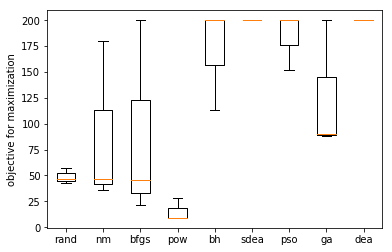

In [9]:
comp()

Note: Scipy methods, `nm`, `bfgs`, `pow`, `bh`, and `sdea`, are not bounded by the number of evaluations (15 in this example).  The rest of the comparison is fair, e.g. `rand` vs. EA-based methods `pso`, `ga`, and `dea`.

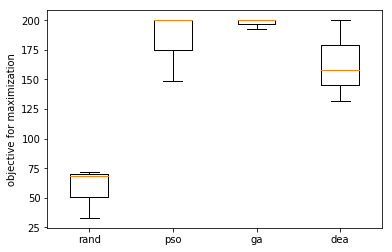

In [27]:
comp(['rand', 'pso', 'ga', 'dea'])

## Pendulum

In [10]:
env = gym.make('Pendulum-v0')
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

mid_dim = 1
num_params = \
    env.observation_space.shape[0] * mid_dim + \
    mid_dim * env.action_space.shape[0]

population_size = 100
num_iterations = 10

Box(1,)
Box(3,)
[1. 1. 8.]
[-1. -1. -8.]


In [11]:
random_run(render=True, trials=1)

Trial ended at 200 time steps


-1463.6705638684066

In [12]:
def run_trial(weights):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        tmp = numpy.dot(observation, weights[0])
        action = numpy.dot(tmp, weights[1])

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def params2weights(parameters):
    assert len(parameters) == num_params
    weights = [
        numpy.zeros(shape=(env.observation_space.shape[0], mid_dim)),
        numpy.zeros(shape=(mid_dim, env.action_space.shape[0]))
    ]
    index = 0
    for i in xrange(env.observation_space.shape[0]):
        for j in xrange(mid_dim):
            weights[0][i, j] = parameters[index]
            index += 1
    for i in xrange(mid_dim):
        for j in xrange(env.action_space.shape[0]):
            weights[1][i, j] = parameters[index]
            index += 1
    return weights

def objective_function(parameters):
    assert len(parameters) == num_params
    weights = params2weights(parameters)
    return run_trial(weights)


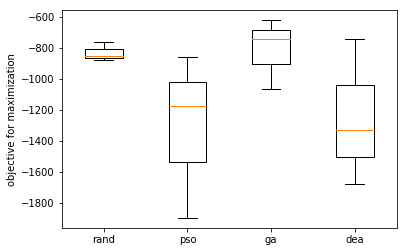

In [14]:
comp(options=['rand', 'pso', 'ga', 'dea'])

## Mountain Car

In [15]:
env = gym.make('MountainCar-v0')

print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

observation_len = 2
action_len = 3

mid_dim = 1
num_params = \
    observation_len * mid_dim + \
    mid_dim * action_len

population_size = 50
num_iterations = 50

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Discrete(3)
Box(2,)
[0.6  0.07]
[-1.2  -0.07]


In [16]:
random_run(render=True, trials=1)

Trial ended at 200 time steps


-200.0

In [17]:
def run_trial(weights):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        tmp = numpy.dot(observation, weights[0])
        tmp = list(numpy.dot(tmp, weights[1]))
        action = tmp.index(max(tmp))

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def params2weights(parameters):
    assert len(parameters) == num_params
    weights = [
        numpy.zeros(shape=(observation_len, mid_dim)),
        numpy.zeros(shape=(mid_dim, action_len))
    ]
    index = 0
    for i in xrange(observation_len):
        for j in xrange(mid_dim):
            weights[0][i, j] = parameters[index]
            index += 1
    for i in xrange(mid_dim):
        for j in xrange(action_len):
            weights[1][i, j] = parameters[index]
            index += 1
    return weights

def objective_function(parameters):
    assert len(parameters) == num_params
    weights = params2weights(parameters)
    return run_trial(weights)


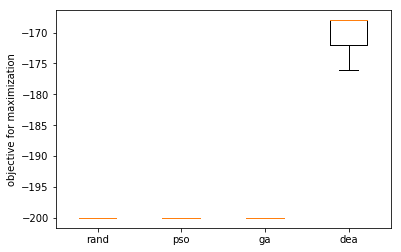

In [19]:
comp(options=['rand', 'pso', 'ga', 'dea'])

## Bipedal Walker

In [30]:
env = gym.make('BipedalWalker-v2')

print(env.action_space)
print()

print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

population_size = 25
num_iterations = 25

observation_len = env.observation_space.shape[0]
action_len = env.action_space.shape[0]

mid_dim = 1
num_params = \
    observation_len * mid_dim + \
    mid_dim * action_len

In [29]:
random_run(render=True, trials=1)

-84.6431283157924

In [31]:
def run_trial(weights):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        tmp = numpy.dot(observation, weights[0])
        action = numpy.dot(tmp, weights[1])

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def params2weights(parameters):
    assert len(parameters) == num_params
    weights = [
        numpy.zeros(shape=(observation_len, mid_dim)),
        numpy.zeros(shape=(mid_dim, action_len))
    ]
    index = 0
    for i in xrange(observation_len):
        for j in xrange(mid_dim):
            weights[0][i, j] = parameters[index]
            index += 1
    for i in xrange(mid_dim):
        for j in xrange(action_len):
            weights[1][i, j] = parameters[index]
            index += 1
    return weights

def objective_function(parameters):
    assert len(parameters) == num_params
    weights = params2weights(parameters)
    return run_trial(weights)

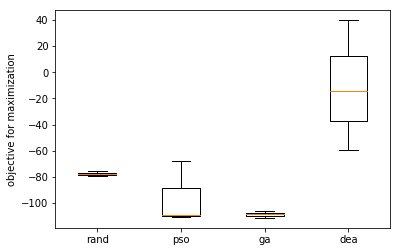

In [32]:
comp(options=['rand', 'pso', 'ga', 'dea'])